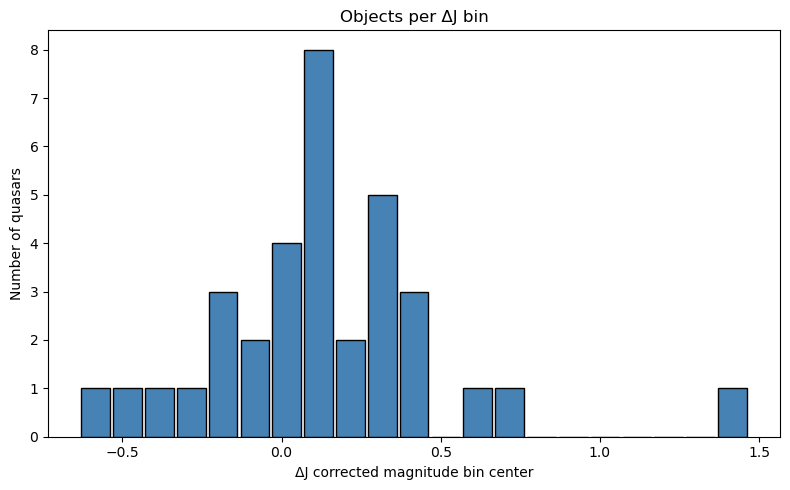

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 1) Read the TSV
# -----------------------------------------------------------
tsv_path = "/utils/catalog.tsv"
df = pd.read_csv(tsv_path, sep="\t")

# keep only numeric ΔJ values
delta_j = pd.to_numeric(df["DeltaJ_corr"], errors="coerce").dropna()

# -----------------------------------------------------------
# 2) ΔJ histogram 
# -----------------------------------------------------------
bin_width = 0.1
bins = np.arange(delta_j.min(), delta_j.max() + bin_width, bin_width)
counts, bin_edges = np.histogram(delta_j, bins=bins)

# Compute bin centers for x-axis labeling
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# -----------------------------------------------------------
# 3) Plot histogram
# -----------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, counts, width=bin_width*0.9, color="steelblue", edgecolor="k")
plt.xlabel("ΔJ corrected magnitude bin center")
plt.ylabel("Number of quasars")
plt.title("Objects per ΔJ bin")
plt.tight_layout()
plt.show()

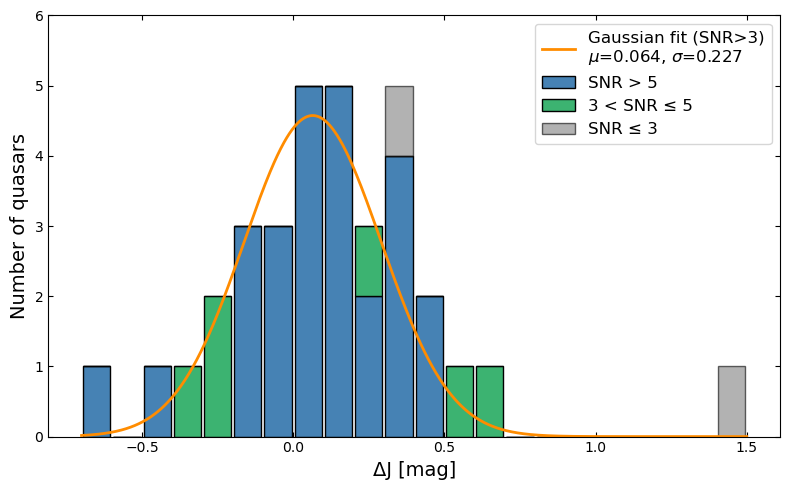

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# -----------------------------------------------------------
# 1) Read TSV
# -----------------------------------------------------------
tsv_path = "/utils/catalog.tsv"
df = pd.read_csv(tsv_path, sep="\t")

# Ensure numeric types
df["SNR"]        = pd.to_numeric(df["SNR"], errors="coerce")
df["DeltaJ_corr"] = pd.to_numeric(df["DeltaJ_corr"], errors="coerce")

# Drop rows without ΔJ
df = df.dropna(subset=["DeltaJ_corr"])

# -----------------------------------------------------------
# 2) Split into three SNR tiers
# -----------------------------------------------------------
df_high = df[df["SNR"] > 5]                 # SNR > 5
df_mid  = df[(df["SNR"] > 3) & (df["SNR"] <= 5)]  # 3 < SNR ≤ 5
df_low  = df[df["SNR"] <= 3]                # SNR ≤ 3

d_high = df_high["DeltaJ_corr"]
d_mid  = df_mid["DeltaJ_corr"]
d_low  = df_low["DeltaJ_corr"]

# -----------------------------------------------------------
# 3) Binning (common bins)
# -----------------------------------------------------------
bin_width = 0.1
bin_start = bin_width * np.floor(df["DeltaJ_corr"].min() / bin_width)
bin_end   = bin_width * np.ceil(df["DeltaJ_corr"].max() / bin_width)
bins = np.arange(bin_start, bin_end + bin_width, bin_width)
bin_centres = (bins[:-1] + bins[1:]) / 2

# Histogram counts per tier
c_high, _ = np.histogram(d_high, bins=bins)
c_mid,  _ = np.histogram(d_mid,  bins=bins)
c_low,  _ = np.histogram(d_low,  bins=bins)

# -----------------------------------------------------------
# 4) Gaussian fit to high‑tier data within |ΔJ| < 0.5
# -----------------------------------------------------------
d_highmid = pd.concat([d_high, d_mid])
fit_data = d_highmid[(d_highmid >= -0.5) & (d_highmid <= 0.5)]
mu, std = norm.fit(fit_data)

x_fit = np.linspace(bin_start, bin_end, 1000)
y_fit = norm.pdf(x_fit, mu, std) * len(d_high) * bin_width

# -----------------------------------------------------------
# 5) Plot
# -----------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.ylim(0, 6)

# High tier (bottom)
plt.bar(bin_centres, c_high, width=bin_width * 0.9,
        color="steelblue", edgecolor="k", label="SNR > 5")

# Mid tier stacked on high
plt.bar(bin_centres, c_mid, width=bin_width * 0.9,
        bottom=c_high,
        color="mediumseagreen", edgecolor="k", label="3 < SNR ≤ 5")

# Low tier stacked on mid
plt.bar(bin_centres, c_low, width=bin_width * 0.9,
        bottom=c_high + c_mid,
        color="gray", edgecolor="k", alpha=0.6, label="SNR ≤ 3")

# Gaussian fit (based on high tier)
plt.plot(x_fit, y_fit, color='darkorange', lw=2,
         label=f"Gaussian fit (SNR>3)\n$\\mu$={mu:.3f}, $\\sigma$={std:.3f}")

# Labels and cosmetics
plt.xlabel("ΔJ [mag]", fontsize=14)
plt.ylabel("Number of quasars", fontsize=14)
plt.tick_params(axis='both', which='both', direction='in',
                top=True, right=True)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

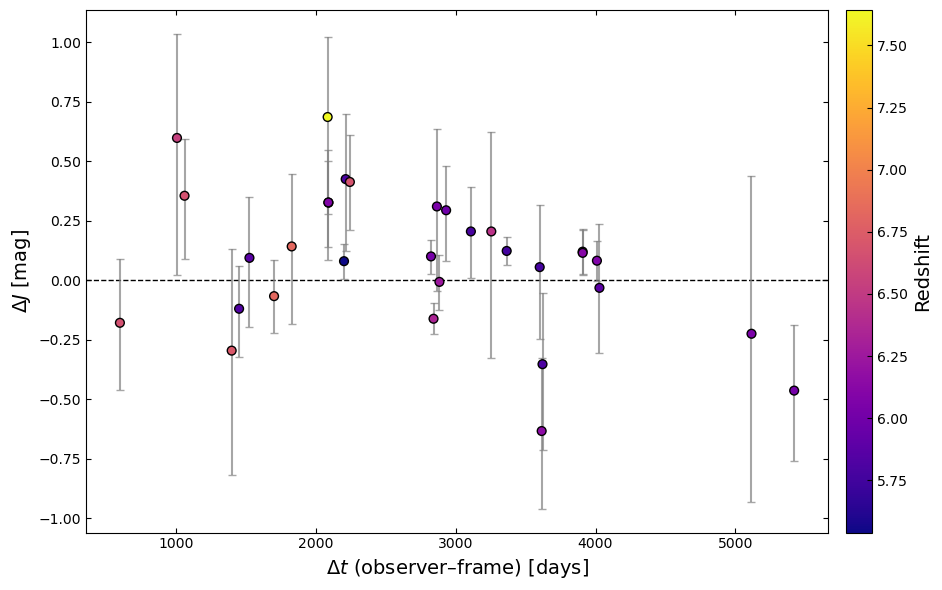

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# SETTINGS
# -----------------------------------------------------------
cmap_name = 'plasma'  # colour-map for redshift

# -----------------------------------------------------------
# 1) Read catalogue and apply SNR > 3 cut
# -----------------------------------------------------------
tsv_path = "/home/jk/Desktop/reduced1/onlyfits/newcatalog.tsv"
df = pd.read_csv(tsv_path, sep="\t")

snr = pd.to_numeric(df["SNR"], errors="coerce")
df = df[snr > 3]

# -----------------------------------------------------------
# 2) Parse dates and compute Δt (days)
# -----------------------------------------------------------
df["ObsDate"] = pd.to_datetime(df["ObsDate"], errors="coerce")
df["RefDate"] = pd.to_datetime(df["RefDate"], errors="coerce")
df["deltat_days"] = (df["ObsDate"] - df["RefDate"]).dt.days

# -----------------------------------------------------------
# 3) Redshift
# -----------------------------------------------------------
df["Redshift"] = pd.to_numeric(df["Redshift"], errors="coerce")

# -----------------------------------------------------------
# 4) ΔJ and asymmetric errors
# -----------------------------------------------------------
df["DeltaJ"]       = pd.to_numeric(df["DeltaJ_corr"],       errors="coerce")
df["DeltaJ_plus"]  = pd.to_numeric(df["DeltaJErr_plus"],    errors="coerce")
df["DeltaJ_minus"] = pd.to_numeric(df["DeltaJErr_minus"],   errors="coerce")

df_plot = df.dropna(subset=["DeltaJ", "DeltaJ_plus", "DeltaJ_minus", "deltat_days", "Redshift"])

# -----------------------------------------------------------
# 5) Plot
# -----------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.axhline(0, color='black', linestyle='--', linewidth=1)

x = df_plot["deltat_days"].values
y = df_plot["DeltaJ"].values
z = df_plot["Redshift"].values
yerr = np.vstack([df_plot["DeltaJ_minus"].values,
                  df_plot["DeltaJ_plus"].values])

# coloured scatter
sc = plt.scatter(x, y, c=z, cmap=cmap_name,
                 s=40, edgecolor='k', zorder=3)

# grey error bars (drawn after so they sit “on top” of points)
plt.errorbar(x, y, xerr=1.0, yerr=yerr,
             fmt='none', ecolor='gray', capsize=3,
             alpha=0.7, zorder=2)


# -----------------------------------------------------------
# 6) Axis labels, colour-bar, cosmetics
# -----------------------------------------------------------
plt.xlabel(r"$\Delta t$ (observer–frame) [days]", fontsize=14)
plt.ylabel(r"$\Delta J$ [mag]", fontsize=14)
#plt.title("ΔJ vs. elapsed time (SNR > 3), colored by redshift")

plt.tick_params(axis='both', which='both', direction='in',
                top=True, right=True)

# colour-bar
cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label("Redshift", fontsize=14)
cbar.ax.tick_params(direction='in')

plt.tight_layout()
plt.show()

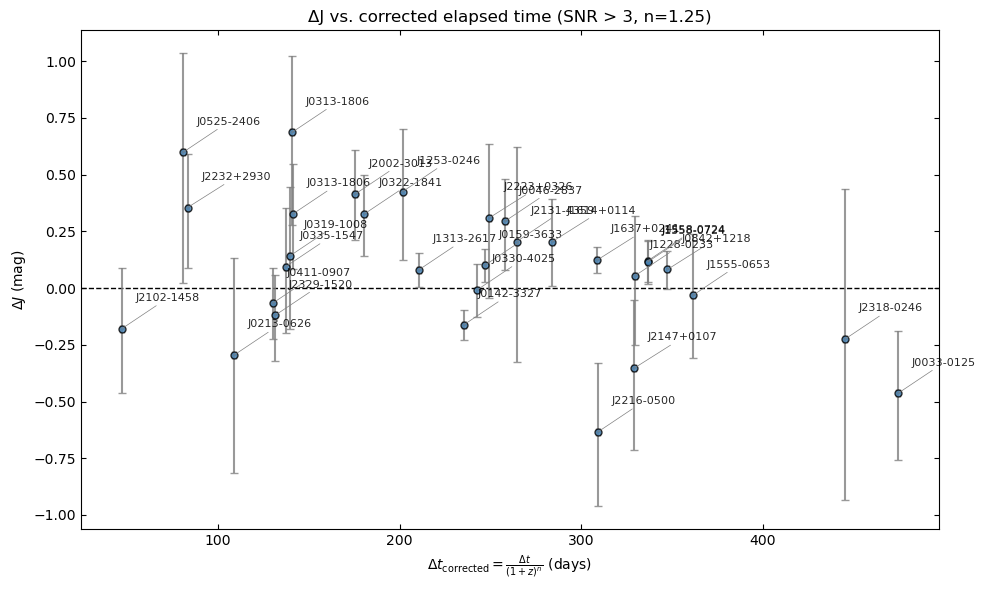

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# SETTINGS
# -----------------------------------------------------------
n = 1.25  # Exponent for time dilation correction: Δt_corrected = Δt / (1 + z)^n 1.25 (Lewis2023)

# -----------------------------------------------------------
# 1) Read catalogue and apply SNR > 3 cut
# -----------------------------------------------------------
tsv_path = "/utils/catalog.tsv"
df = pd.read_csv(tsv_path, sep="\t")

snr = pd.to_numeric(df["SNR"], errors="coerce")
df = df[snr > 3]  # keep only high-SNR rows

# -----------------------------------------------------------
# 2) Parse dates and compute Δt (days)
# -----------------------------------------------------------
df["ObsDate"] = pd.to_datetime(df["ObsDate"], errors="coerce")
df["RefDate"] = pd.to_datetime(df["RefDate"], errors="coerce")
df["deltat_days"] = (df["ObsDate"] - df["RefDate"]).dt.days

# -----------------------------------------------------------
# 3) Read redshift and calculate corrected elapsed time
# -----------------------------------------------------------
df["Redshift"] = pd.to_numeric(df["Redshift"], errors="coerce")

# Avoid division by zero or negative redshifts by filtering:
df = df[df["Redshift"] >= 0]

# Calculate corrected elapsed time:
df["deltat_corrected"] = df["deltat_days"] / ((1 + df["Redshift"]) ** n)

# -----------------------------------------------------------
# 4) Get ΔJ and its asymmetric errors
# -----------------------------------------------------------
df["DeltaJ"]       = pd.to_numeric(df["DeltaJ_corr"],       errors="coerce")
df["DeltaJ_plus"]  = pd.to_numeric(df["DeltaJErr_plus"],    errors="coerce")
df["DeltaJ_minus"] = pd.to_numeric(df["DeltaJErr_minus"],   errors="coerce")

# Drop rows with NaNs in essential columns
df_plot = df.dropna(subset=["DeltaJ", "DeltaJ_plus", "DeltaJ_minus", "deltat_corrected"])


plt.figure(figsize=(10, 6))
plt.axhline(0, color='black', linestyle='--', linewidth=1)


x = df_plot["deltat_corrected"].values
y = df_plot["DeltaJ"].values
yerr = np.vstack([df_plot["DeltaJ_minus"].values,
                  df_plot["DeltaJ_plus"].values])
objects = df_plot["Object"].values

plt.errorbar(x, y,
             xerr=1.0,
             yerr=yerr,
             fmt="o", ms=5, mfc="steelblue", mec="k",
             ecolor="gray", capsize=3, alpha=0.8)

# Annotate each point with connector line
for xi, yi, label in zip(x, y, objects):
    plt.annotate(
        label,
        xy=(xi, yi),
        xytext=(10, 20),  # More offset to reduce overlap
        textcoords="offset points",
        ha='left', fontsize=8, alpha=0.85,
        arrowprops=dict(arrowstyle="-", lw=0.5, color="gray", shrinkA=0, shrinkB=0)
    )

plt.xlabel(r"$\Delta t_{\mathrm{corrected}} = \frac{\Delta t}{(1 + z)^n}$ (days)")
plt.ylabel(r"$\Delta J$ (mag)")
plt.title(f"ΔJ vs. corrected elapsed time (SNR > 3, n={n})")

plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)

plt.tight_layout()
plt.show()

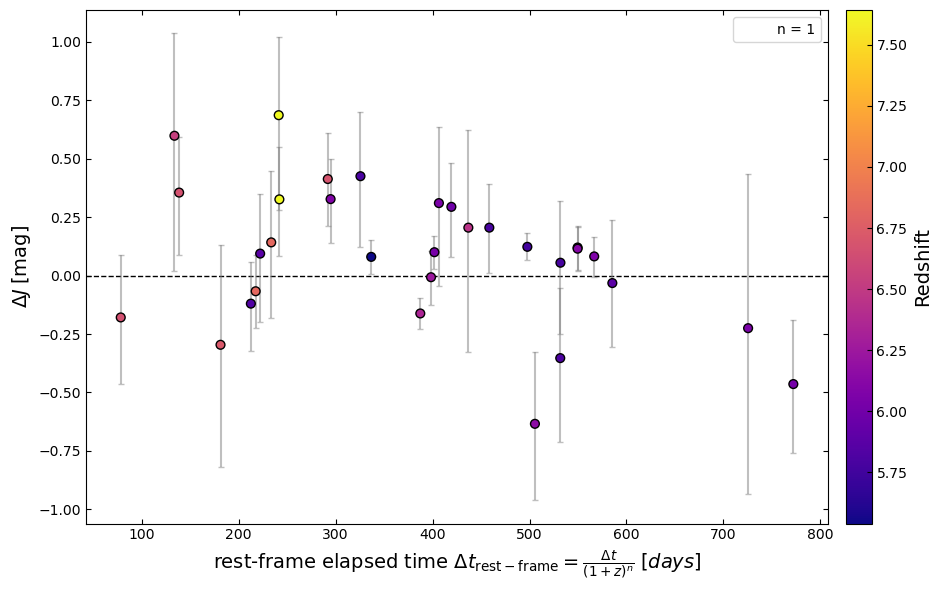

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# SETTINGS
# -----------------------------------------------------------
n = 1          # exponent for Δt / (1+z)^n
cmap_name = 'plasma'  # colour‑map for redshift

# -----------------------------------------------------------
# 1) Read catalogue and apply SNR > 3 cut
# -----------------------------------------------------------
tsv_path = "/utils/catalog.tsv"
df = pd.read_csv(tsv_path, sep="\t")

snr = pd.to_numeric(df["SNR"], errors="coerce")
df  = df[snr > 3]

# -----------------------------------------------------------
# 2) Parse dates and compute Δt (days)
# -----------------------------------------------------------
df["ObsDate"] = pd.to_datetime(df["ObsDate"], errors="coerce")
df["RefDate"] = pd.to_datetime(df["RefDate"], errors="coerce")
df["deltat_days"] = (df["ObsDate"] - df["RefDate"]).dt.days

# -----------------------------------------------------------
# 3) Redshift and corrected elapsed time
# -----------------------------------------------------------
df["Redshift"] = pd.to_numeric(df["Redshift"], errors="coerce")
df             = df[df["Redshift"] >= 0]      # keep only valid z
df["deltat_corrected"] = df["deltat_days"] / ((1 + df["Redshift"])**n)

# -----------------------------------------------------------
# 4) ΔJ and asymmetric errors
# -----------------------------------------------------------
df["DeltaJ"]       = pd.to_numeric(df["DeltaJ_corr"],       errors="coerce")
df["DeltaJ_plus"]  = pd.to_numeric(df["DeltaJErr_plus"],    errors="coerce")
df["DeltaJ_minus"] = pd.to_numeric(df["DeltaJErr_minus"],   errors="coerce")

df_plot = df.dropna(subset=["DeltaJ", "DeltaJ_plus", "DeltaJ_minus",
                            "deltat_corrected", "Redshift"])

# -----------------------------------------------------------
# 5) Plot
# -----------------------------------------------------------
plt.figure(figsize=(10, 6))

plt.axhline(0, color='black', linestyle='--', linewidth=1)

x = df_plot["deltat_corrected"].values
y = df_plot["DeltaJ"].values
z = df_plot["Redshift"].values
yerr = np.vstack([df_plot["DeltaJ_minus"].values,
                  df_plot["DeltaJ_plus"].values])

# coloured scatter
sc = plt.scatter(x, y, c=z, cmap=cmap_name,
                 s=40, edgecolor='k', zorder=3)

# grey error bars (drawn after so they sit “on top” of points)
plt.errorbar(x, y, xerr=1.0, yerr=yerr,
             fmt='none', ecolor='gray', capsize=2,
             alpha=0.5, zorder=2)


# -----------------------------------------------------------
# 7) Axis labels, colour‑bar, cosmetics
# -----------------------------------------------------------
plt.xlabel(r"rest-frame elapsed time $\Delta t_{\mathrm{rest-frame}} = \frac{\Delta t}{(1 + z)^n}\;[days]$", fontsize=14)
plt.ylabel(r"$\Delta J \; [\mathrm{mag}]$", fontsize=14)
#plt.title(f"ΔJ vs. rest‑frame elapsed time (SNR > 3, n={n})", fontsize=14)

plt.tick_params(axis='both', which='both', direction='in',
                top=True, right=True)

# colour‑bar
cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label("Redshift", fontsize=14)
cbar.ax.tick_params(direction='in')

plt.plot([], [], ' ', label='n = {}'.format(n))
plt.legend()

plt.tight_layout()
plt.show()

16 points remaining after filtering
   BHmass  DeltaJ  DeltaJ_plus  DeltaJ_minus  Redshift
0    2.27  -0.464        0.275         0.294    6.0190
1    3.51   0.294        0.188         0.214    5.9910
2   25.89  -0.162        0.066         0.066    6.3373
3   64.40   0.100        0.071         0.073    6.0270
5   16.09   0.326        0.222         0.241    7.6423


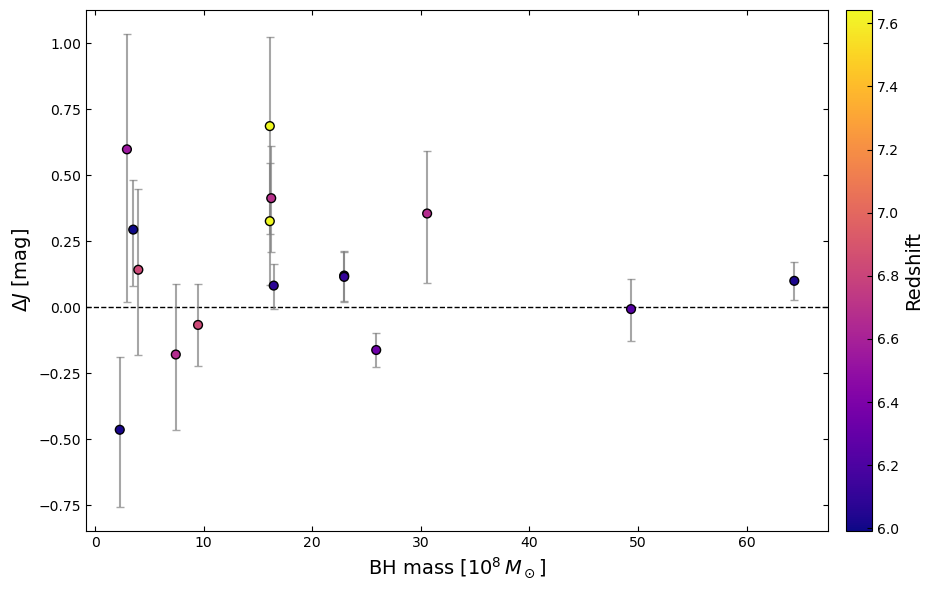

In [35]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re

# -----------------------------------------------------------
# SETTINGS
# -----------------------------------------------------------
cmap_name       = "plasma"
parent_folder   = "/utils/fits_folder"
photometry_path = os.path.join(parent_folder, "photometry_matches.tsv")
newcatalog_path = os.path.join(parent_folder, "catalog.tsv")

filename_col = "Object"  # This should contain the long filenames like 'J0033-0125_ap5p0_...'

# -----------------------------------------------------------
# 1) Read both TSV files
# -----------------------------------------------------------
df_phot = pd.read_csv(photometry_path, sep="\t")
df_new  = pd.read_csv(newcatalog_path,  sep="\t")

if filename_col not in df_phot.columns:
    raise KeyError(f"'{filename_col}' column not found in photometry_matches.tsv")

# -----------------------------------------------------------
# 2) Keep only rows with 'ap5p' in the filename
# -----------------------------------------------------------
df_phot = df_phot[df_phot[filename_col].str.contains("ap5p")]

# -----------------------------------------------------------
# 3) Extract the J-name (e.g. J0033-0125) from the filename
# -----------------------------------------------------------
def extract_jname(fname):
    match = re.match(r"(J\d{4}[+-]\d{4})_ap5p", fname)
    return match.group(1) if match else None

df_phot["ObjName"] = df_phot[filename_col].apply(extract_jname)
df_phot = df_phot.dropna(subset=["ObjName"])

# -----------------------------------------------------------
# 4) Merge on J-name with newcatalog.tsv's 'Object' column
# -----------------------------------------------------------
if "Object" not in df_new.columns:
    raise KeyError("'Object' column not found in newcatalog.tsv")

df = pd.merge(
    df_phot,
    df_new[["Object", "DeltaJ_corr", "DeltaJErr_plus", "DeltaJErr_minus", "Redshift"]],
    left_on="ObjName",
    right_on="Object",
    how="inner"
)

# -----------------------------------------------------------
# 5) Apply SNR > 3 cut
# -----------------------------------------------------------
df["SNR"] = pd.to_numeric(df["SNR"], errors="coerce")
df = df[df["SNR"] > 3]

# -----------------------------------------------------------
# 6) Get BH mass
# -----------------------------------------------------------
df["BHmass"] = pd.to_numeric(df["BHmass_1e8Msun"], errors="coerce")

# -----------------------------------------------------------
# 7) Convert ΔJ and errors to numeric
# -----------------------------------------------------------
df["DeltaJ"]       = pd.to_numeric(df["DeltaJ_corr"],     errors="coerce")
df["DeltaJ_plus"]  = pd.to_numeric(df["DeltaJErr_plus"],  errors="coerce")
df["DeltaJ_minus"] = pd.to_numeric(df["DeltaJErr_minus"], errors="coerce")
df["Redshift"] = pd.to_numeric(df["Redshift_x"], errors="coerce")

# -----------------------------------------------------------
# 8) Drop rows with missing essentials
# -----------------------------------------------------------
df_plot = df.dropna(subset=["BHmass", "DeltaJ", "DeltaJ_plus",
                            "DeltaJ_minus", "Redshift"])

# Debug: show remaining points
print(f"{len(df_plot)} points remaining after filtering")
print(df_plot[["BHmass", "DeltaJ", "DeltaJ_plus", "DeltaJ_minus", "Redshift"]].head())

# -----------------------------------------------------------
# 9) Plot
# -----------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.axhline(0, color="black", linestyle="--", linewidth=1)

x = df_plot["BHmass"].values
y = df_plot["DeltaJ"].values
z = df_plot["Redshift"].values
yerr = np.vstack([df_plot["DeltaJ_minus"], df_plot["DeltaJ_plus"]])

sc = plt.scatter(x, y, c=z, cmap=cmap_name,
                 s=40, edgecolor="k", zorder=3)

plt.errorbar(x, y, yerr=yerr,
             fmt="none", ecolor="gray", capsize=3,
             alpha=0.7, zorder=2)

plt.xlabel(r"BH mass [$10^{8}\,M_\odot$]", fontsize=14)
plt.ylabel(r"$\Delta J$ [mag]", fontsize=14)
plt.tick_params(axis="both", direction="in", top=True, right=True)

cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label("Redshift", fontsize=14)
cbar.ax.tick_params(direction="in")

plt.tight_layout()
plt.show()

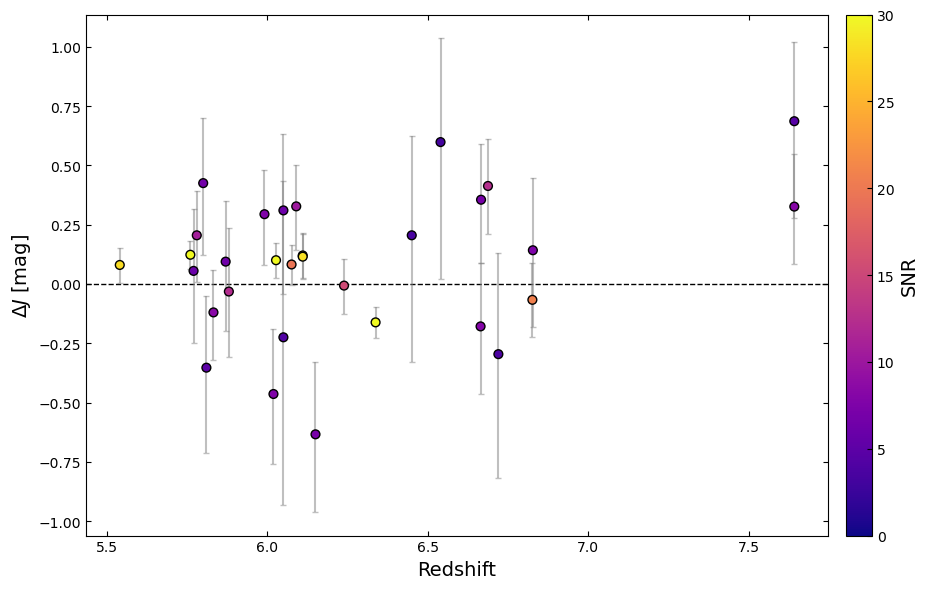

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# SETTINGS
# -----------------------------------------------------------
n = 1          # exponent for Δt / (1+z)^n
cmap_name = 'plasma'  # colour‑map for SNR

# -----------------------------------------------------------
# 1) Read catalogue and apply SNR > 3 cut
# -----------------------------------------------------------
tsv_path = "/utils/catalog.tsv"
df = pd.read_csv(tsv_path, sep="\t")

df["SNR"] = pd.to_numeric(df["SNR"], errors="coerce")
df = df[df["SNR"] > 3]

# -----------------------------------------------------------
# 2) Parse dates and compute Δt (days)
# -----------------------------------------------------------
df["ObsDate"] = pd.to_datetime(df["ObsDate"], errors="coerce")
df["RefDate"] = pd.to_datetime(df["RefDate"], errors="coerce")
df["deltat_days"] = (df["ObsDate"] - df["RefDate"]).dt.days

# -----------------------------------------------------------
# 3) Redshift and corrected elapsed time
# -----------------------------------------------------------
df["Redshift"] = pd.to_numeric(df["Redshift"], errors="coerce")
df = df[df["Redshift"] >= 0]  # keep only valid redshifts
df["deltat_corrected"] = df["deltat_days"] / ((1 + df["Redshift"])**n)

# -----------------------------------------------------------
# 4) ΔJ and asymmetric errors
# -----------------------------------------------------------
df["DeltaJ"]       = pd.to_numeric(df["DeltaJ_corr"],       errors="coerce")
df["DeltaJ_plus"]  = pd.to_numeric(df["DeltaJErr_plus"],    errors="coerce")
df["DeltaJ_minus"] = pd.to_numeric(df["DeltaJErr_minus"],   errors="coerce")

df_plot = df.dropna(subset=["DeltaJ", "DeltaJ_plus", "DeltaJ_minus",
                            "deltat_corrected", "Redshift", "SNR"])

# -----------------------------------------------------------
# 5) Plot ΔJ vs Redshift, color-coded by SNR
# -----------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.axhline(0, color='black', linestyle='--', linewidth=1)

x = df_plot["Redshift"].values
y = df_plot["DeltaJ"].values
z = df_plot["SNR"].values  # color by SNR

yerr = np.vstack([df_plot["DeltaJ_minus"].values,
                  df_plot["DeltaJ_plus"].values])


vmin_value = 0
vmax_value = 30

sc = plt.scatter(x, y, c=z, cmap=cmap_name, s=40, edgecolor='k', 
                 zorder=3, vmin=vmin_value, vmax=vmax_value)


plt.errorbar(x, y, yerr=yerr,
             fmt='none', ecolor='gray', capsize=2,
             alpha=0.5, zorder=2)

plt.xlabel("Redshift", fontsize=14)
plt.ylabel(r"$\Delta J$ [mag]", fontsize=14)
plt.tick_params(axis='both', which='both', direction='in',
                top=True, right=True)

cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label("SNR", fontsize=14)
cbar.ax.tick_params(direction='in')


plt.tight_layout()
plt.show()